In [126]:
#
# Exmaple of using pynumero to compute hessian and reduced hessian for a OLS example
#

In [127]:
# import modules
import pyomo.environ as pyo
from pyomo.contrib.pynumero.interfaces.pyomo_nlp import PyomoNLP
from pyomo.contrib.pynumero.sparse import BlockSymMatrix, BlockMatrix, BlockVector
from scipy.sparse import identity
from scipy.sparse.linalg import spsolve
import numpy as np
import matplotlib.pyplot as plt

In [152]:
def getvarorder(nlp, parm_vars, non_parm_vars):
    # ensure that variable order from original hessian is preserved
    varnames = [x.name for x in nlp.get_pyomo_variables()]
    print(varnames)

    curr_order = {k.name:i for (i,k) in enumerate(non_parm_vars)}
    parm_order = {k.name:(i + len(curr_order)) for (i,k) in enumerate(parm_vars)}
    curr_order.update(parm_order)
    print(curr_order)

    zorder = [curr_order[k] for k in varnames]
    print('zorder:', zorder)
    
    return zorder

def getZ(nlp, parm_vars):
    # Get the Z matrix to compute reduced hessian
    non_parm_vars = [x for x in nlp.get_pyomo_variables() if x not in parm_vars]
    
    Ji = nlp.extract_submatrix_jacobian(pyomo_variables = parm_vars, pyomo_constraints=nlp.get_pyomo_constraints())
    Jd = nlp.extract_submatrix_jacobian(pyomo_variables = non_parm_vars, pyomo_constraints=nlp.get_pyomo_constraints())
    print("Ji")
    print(Ji.todense())
    print("Jd")
    print(Jd.todense())

    Zd = spsolve(Jd.tocsc(), Ji.tocsc())
    Z = BlockMatrix(2, 1)
    Z[0, 0] = Zd
    Z[1, 0] = identity(len(parm_vars))
    print("Z")
    print(Z.todense())
    
    # reorder variables to the order in hessian
    zorder = getvarorder(nlp, parm_vars, non_parm_vars)
    Zorder = Z.tocsc()[zorder, :].todense()
    print("Zorder")
    print(Zorder)
    
    return Zorder

def getHred(nlp, parm_vars):
    # compute reduced hessian
    H = nlp.evaluate_hessian_lag()
    if nlp.n_primals() == len(parm_vars):
        Hred = H.todense()
    else:
        Zorder = getZ(nlp, parm_vars)
        Hred = Zorder.T.dot(H.dot(Zorder))
    return Hred

In [129]:
# generate simulated data for OLS
# X matrix
x0 = np.ones(5)
x1 = np.array([1, 2, 3, 4, 5])
X = np.vstack([x0, x1]).T
print("X:\n", X)

# beta actual
beta = np.array([10.0, 5.0])

# y
yact = X.dot(beta)


# add random normal noise with variance 5
y = yact + np.random.randn(5) * 5

X:
 [[1. 1.]
 [1. 2.]
 [1. 3.]
 [1. 4.]
 [1. 5.]]


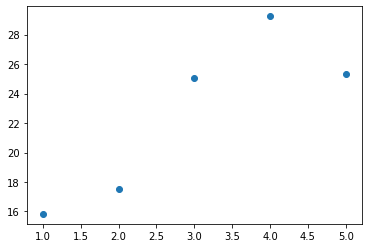

In [130]:
fig, ax = plt.subplots()
ax.scatter(X[:, 1], y)
plt.show()

In [146]:
# OLS model 1 using just beta variables
parms = [0, 1]
expts = [0, 1, 2, 3, 4] 
m = pyo.ConcreteModel()
m.beta = pyo.Var(parms)
m.obj = pyo.Objective(expr = sum((y[k] - sum(X[k, j] * m.beta[j] for j in parms))**2 for k in expts))

In [147]:
opt = pyo.SolverFactory('ipopt')
results = opt.solve(m, tee=True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0


beta_est: [13.37186405  3.07426231]


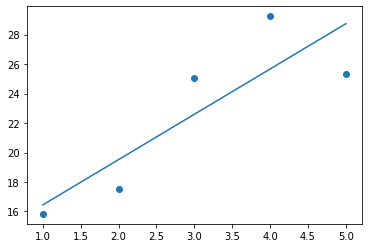

In [148]:
beta_est = np.array([m.beta[0](), m.beta[1]()])
print('beta_est:', beta_est)
y_pred = X.dot(beta_est)

fig, ax = plt.subplots()
ax.scatter(X[:, 1], y)
ax.plot(X[:, 1], y_pred)
plt.show()

In [154]:
nlp = PyomoNLP(m)
parm_vars = [m.beta[0], m.beta[1]]
H = getHred(nlp, parm_vars)
print("Hessian from pynumero:")
print(H)
print("Analytical Hessian 2*X^TX")
Ha = 2*X.T.dot(X)
print(Ha)

Hessian from pynumero:
[[ 10.  30.]
 [ 30. 110.]]
Analytical Hessian 2*X^TX
[[ 10.  30.]
 [ 30. 110.]]


In [156]:
# OLS model 2 using beta variables and ypred variables
parms = [0, 1]
expts = [0, 1, 2, 3, 4] 
m = pyo.ConcreteModel()
m.beta = pyo.Var(parms)
m.ypred = pyo.Var(expts)

m.obj = pyo.Objective(expr = sum((m.ypred[k] - y[k])**2 for k in expts))
def _cons(m, k):
    return m.ypred[k] == sum(X[k, j] * m.beta[j] for j in parms)
m.cons = pyo.Constraint(expts, rule = _cons)        

In [157]:
opt = pyo.SolverFactory('ipopt')
results = opt.solve(m, tee=True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:       15
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        5

Total number of variables............................:        7
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0


beta_est: [13.37186405  3.07426231]


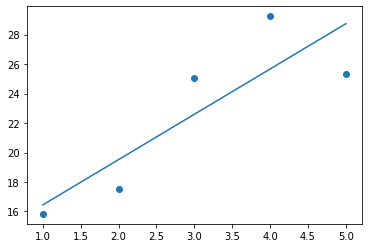

In [158]:
beta_est = np.array([m.beta[0](), m.beta[1]()])
print('beta_est:', beta_est)
y_pred = X.dot(beta_est)

fig, ax = plt.subplots()
ax.scatter(X[:, 1], y)
ax.plot(X[:, 1], y_pred)
plt.show()

In [160]:
nlp = PyomoNLP(m)
parm_vars = [m.beta[0], m.beta[1]]
Hred = getHred(nlp, parm_vars)
print("Hessian from pynumero:")
print(Hred)
print("Analytical Hessian 2*X^TX")
Ha = 2*X.T.dot(X)
print(Ha)

Ji
[[-1. -1.]
 [-1. -2.]
 [-1. -3.]
 [-1. -4.]
 [-1. -5.]]
Jd
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
Z
[[-1. -1.]
 [-1. -2.]
 [-1. -3.]
 [-1. -4.]
 [-1. -5.]
 [ 1.  0.]
 [ 0.  1.]]
['ypred[0]', 'ypred[1]', 'ypred[2]', 'ypred[3]', 'ypred[4]', 'beta[0]', 'beta[1]']
{'ypred[0]': 0, 'ypred[1]': 1, 'ypred[2]': 2, 'ypred[3]': 3, 'ypred[4]': 4, 'beta[0]': 5, 'beta[1]': 6}
zorder: [0, 1, 2, 3, 4, 5, 6]
Zorder
[[-1. -1.]
 [-1. -2.]
 [-1. -3.]
 [-1. -4.]
 [-1. -5.]
 [ 1.  0.]
 [ 0.  1.]]
Hessian from pynumero:
[[ 10.  30.]
 [ 30. 110.]]
Analytical Hessian 2*X^TX
[[ 10.  30.]
 [ 30. 110.]]
